# Estimate p-Thyrosim parameters


+ **9/8/2020** Fit exact THS values for schneider patients. Use starting TSH values (**TSH.preop**) as response, and only include patients who had 0 dose changes (i.e. initial and euthyroid dose is the same)

+ **8/27/2020** Met with distefano. He suggested stop fitting Km values and to put bounds on the parameter space. 

+ ** 8/19/2020** Schneider loglikelihood got worse after 24h fitting because blakesley dominated the error. This time, try starting with model fitted to blakesley data and only fit schneider error. Also add logl tracker for different BMI/sex categories to monitor them separately. 

+ ** 8/10/2020** Separate Schneider fit by sex and BMI category. Estimate mean and variance from each category separately. 

+ ** 8/10/2020** Fitting works but bias due to sex still remains. Try fitting female reference Vp volume. 

+ ** 7/23/2020** Fix bug in loglikelihood calculation. First we fit blakesley data only to obtain reasonable fit, then use that as starting point to fit all 3 datasets on the cluster.

+ ** 7/18/2020** Mauricio compiled a list of parameters by searching through Thyrosim paper's history. We will re-fit all parameters that were fitted before.

+ **6/21/2020** Now we try maximum likelihood approach because it is easier to justify compared to our previous approach. We assume data from each compartment T4/T3/TSH are independent gaussian with some variance $\sigma_{T4}, \sigma_{T3}, \sigma_{TSH}$. Then we treat the ODE solution as the mean of the response ($\mu$). The negative loglikelihood for each compartment is
$$\frac{n\log(2\pi)}{2} + n\log(\sigma) + \sum\frac{(y - \mu)^2}{2\sigma^2}.$$
We minimize this function summed over T4/T3/TSH compartments. For Schneider's data, we use mean dosage predicted as the mean of the response, where the $y$s are the euthyroid dose. Also, for Blakesley patients, the initial condition for every compartment is now set to steady state by letting the model run for 30 days prior to fitting. 


+ **5/17/2020**: What I tried on 5/13 doesn't work. If Blakesley T3 and Jonklaas gets fitted, schneider prediction will look bad (see `test` branch on Github). Thus now I try to fit every rate in the thyroid hormone distribution and elimination submodel (Fig 3 of Eisenburg 2008) along with the 6 parameters we introduced for the hill functions. Also, we only fit on schneider toy data since our previous best fit was obtained from a toy data fit. 


+ **5/13/2020**: Things I tried for past 2 weeks didn't really work. Now I will start with the best model we have (obtained on 4/28) and try to fix the problems with it. Namely, the T3 values in Blakesley are too low. We fix this issue by fitting S3, k05, k3dissolve and k3excrete. We do not fit k3absorb because it is a parameter adjustable on Thyrosim website (default 0.88).


+ **4/30/2020 notes**: Blakesley T3 fit keep screwing up. Thus we start fitting T3 secretion and excretion rate. This is achieved by making `dial` part of the `p` parameter. 


+ **4/21/2020 notes**: In `problem_diagnostics.ipynb` and `schneider_avg_predicted_dose.svg`, predicted dose for skinnier patients are overestimated. Plotting a few normal patients reveal that while ~2.3ug/kg T4 is sufficient, ~1.8ug give rise to large (~4.5) TSH values. Perhaps scaling the error function by 0.22 introduced in 3/29 is causing this screw as smaller dose is forced to approach TSH 4.5. Back then, we were fitting k21 and k31 which we shouldn't be. Therefore we try getting rid of the scaling. Also, we try **include Blakesley's T3 data in fitting**.


+ **4/14/2020 notes**: Realized we shouldn't be fitting k21 and k31. Instead, fit k02 and k05 because they are the terms that handle T4/T3 eliminations. Also, use absolute error in objective instead of scaled error, because otherwise one of the hill coefficients will want to blowup to infinity. 

    Furthremore, Mauricio's python notebook for Schneider's data shows that:
    + We are underpredicting doses for males and overpredicting for females. **This suggests a problem with our model's sex parametrization that is somewhat deeper than fitting**
    

+ **3/29/2020 notes**: According to `problem_diagnostics.ipynb`, the current fit improves error by making every dose achieve euthyroidism. This leads to severely underpredicted T4 dose: median predicted euthyroid dose is ~0.5ug/kg while in real data it should be ~1.6. The reason might be because we have no schneider patients that's is supposed to have a *"high TSH level"*. To solve this problem, we will assign an error of 
$$\log(4.5 / TSH) / 0.22$$
for patients whose predicted TSH is within normal range but whose initial dose is smaller than their euthyroid dose (i.e. we know the initial dose is insufficient). Division by 0.22 is because only 91 / 400 patients satisfy this criteria, so we scale up their error proportion.

In [1]:
using Revise
using DifferentialEquations
using Thyrosim
using DiffEqCallbacks
using DiffEqParamEstim
using Plots
using Optim
using Statistics

In [2]:
Threads.nthreads()

8

## Import data and initial conditions

In [3]:
#schneider data
train, test, toy = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

In [4]:
function objective(
    p_being_optimized::Vector, 
    fitting_index::Vector, 
    lowerbound::Vector,
    upperbound::Vector,
    categories::Dict,
    blakesley_time::Matrix,
    blakesley_my400_data::Matrix, 
    blakesley_my450_data::Matrix, 
    blakesley_my600_data::Matrix,
    jonklaas_time::Vector, 
    jonklaas_patient_t4::Matrix, 
    jonklaas_patient_t3::Matrix, 
    jonklaas_patient_tsh::Matrix, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    schneider_height::Vector, 
    schneider_weight::Vector, 
    schneider_sex::Vector, 
    schneider_tspan::Vector, 
    schneider_init_tsh::Vector, 
    schneider_euthy_dose::Vector, 
    schneider_init_dose::Vector;      
    verbose::Bool = false #set to true to display intermediate errors
    )
    
    total_neg_logl = 0.0
    # quick return
    for (i, val) in enumerate(p_being_optimized)
        if val < lowerbound[i] || val > upperbound[i]
            return Inf
        end
    end
    #
    # Blakesley
    #
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= p_being_optimized
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
    p_400 = p_450 = p_600 = copy(p)
    find_patient_ic!(ic, p_400, 30)
#     T4_init_400, T3_init_400, TSH_init_400 = blakesley_my400_data[1, :]
#     T4_init_450, T3_init_450, TSH_init_450 = blakesley_my450_data[1, :]
#     T4_init_600, T3_init_600, TSH_init_600 = blakesley_my600_data[1, :]
    # solve different ODE problems for varying doses
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 4, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 4, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 4, 7])
    T4_error = blakesley_t4_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[47], p[61]) + 
               blakesley_t4_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[47], p[61]) + 
               blakesley_t4_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[47], p[61])
    T3_error = blakesley_t3_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[47], p[62]) + 
               blakesley_t3_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[47], p[62]) + 
               blakesley_t3_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[47], p[62])
    TSH_error = blakesley_tsh_neg_logl(sol_400, blakesley_time, blakesley_my400_data, p[48], p[63]) + 
                blakesley_tsh_neg_logl(sol_450, blakesley_time, blakesley_my450_data, p[48], p[63]) + 
                blakesley_tsh_neg_logl(sol_600, blakesley_time, blakesley_my600_data, p[48], p[63])
    blakesley_err = T4_error + T3_error + TSH_error
    verbose && println("blakesley negative loglikelihood: T4 = $T4_error, T3 = $T3_error, TSH = $TSH_error")
    total_neg_logl += blakesley_err
    #
    # Jonklaas
    #
    tspan = (0.0, 8.0)
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    jonklaas_err = 0.0
    for i in 1:size(jonklaas_patient_dose, 1)
        # initialize ODE problem for patient 1
        height, weight, sex = jonklaas_patient_param[i, :]
        T4init, T3init, TSHinit = jonklaas_patient_t4[i, 1], jonklaas_patient_t3[i, 1], jonklaas_patient_tsh[i, 1]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        # set parameters being fitted
        p[fitting_index] .= p_being_optimized
        # solve different ODE problems for varying doses
        p[56] = jonklaas_patient_dose[i] / 651.0
        prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
        sol  = solve(prob, save_idxs=4)
        jonklaas_err += jonklaas_t3_neg_logl(sol, jonklaas_time, 
            jonklaas_patient_t3[i, :], p[47], p[62])
    end
    verbose && println("jonklaas's negative loglikelihood = $jonklaas_err")
    total_neg_logl += jonklaas_err
    #
    # Schneider
    #
    num_params = length(p_being_optimized)
    num_sample = length(schneider_height)
    num_params == length(fitting_index) || error("check parameter length bro")
    logl_by_categories = [zeros(6*8) for _ in 1:Threads.nthreads()] # male normal/overwt/obese, then female
    Threads.@threads for i in 1:num_sample
        # get current patient's distribution 
        sex = schneider_sex[i]
        h = schneider_height[i]
        w = schneider_weight[i]
        μ, σ = get_category(categories, sex, h, w)
        
        #calculate each observations neg likelihood (units in mcg/kg)
        logobs = schneider_logobs(p_being_optimized, fitting_index, μ, σ, 
            h, w, sex, schneider_tspan[i], schneider_init_tsh[i], 
            schneider_euthy_dose[i], schneider_init_dose[i])
        
        id = Threads.threadid()
        update_logl_by_category!(logl_by_categories[id], logobs, sex, h, w)
    end
    tot_logl_by_categories = sum(logl_by_categories)
    schneider_logl = sum(tot_logl_by_categories)
    if verbose 
        println("schneider's negative loglikelihood = $schneider_logl")
        println("    male normal     = ", tot_logl_by_categories[8])
        println("    male overweight = ", tot_logl_by_categories[16])
        println("    male obese      = ", tot_logl_by_categories[24])
        println("    female normal     = ", tot_logl_by_categories[32])
        println("    female overweight = ", tot_logl_by_categories[40])
        println("    female obese      = ", tot_logl_by_categories[48])
    end
    total_neg_logl += schneider_logl
    #
    # Return final error
    #
    return total_neg_logl
end

objective (generic function with 1 method)

### Helper functions for calculating error

In [5]:
# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end
# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end
# define function for adding dose
function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end
function blakesley_t4_neg_logl(sol, time, data, Vp, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_t3_neg_logl(sol, time, data, Vp, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i])[2] * 651.0 / Vp
            tot_loss += (T3_predicted - data[i, 2])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function blakesley_tsh_neg_logl(sol, time, data, Vtsh, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[3] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
function jonklaas_t3_neg_logl(sol, time, data, Vp, σ)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        n = length(time)
        for i in 1:n
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
        tot_loss /= 2σ^2
        tot_loss += n * log(2π) / 2 + n * log(σ)
    end
    return tot_loss
end
# calculates mean passing dose (mcg/kg) and returns negative loglikelihood of this observation
function schneider_logobs( 
    current_iter::Vector,
    fitting_index::Vector, 
    μ::Float64, # mean of euthyroid dose for a group
    σ::Float64, # std  of euthyroid dose for a group
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )

    possible_doses = 50.0:12.5:325.0
    mindose = 0.0
    maxdose = 0.0

    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter

    # check doses from bottom up
    for dose in possible_doses
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])

        # save doses that work
        if TSH_within_interval(sol, p[48])
            mindose = dose
            break
        end
    end
    if mindose == 0 
        mindose = Inf
    end

    # check doses from top to bottom
    for dose in Iterators.reverse(possible_doses)
        p[55] = dose / 777.0
        prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
        sol   = solve(prob, save_idxs=[1, 7])

        # save doses that work
        if TSH_within_interval(sol, p[48])
            maxdose = dose
            break
        end
    end
    if maxdose == 0 
        maxdose = Inf
    end

    y = (maxdose + mindose) / 2 / weight
    return log(2π) / 2 + log(σ) + (y - μ)^2 / 2 / σ^2
end
function TSH_within_interval(sol, Vtsh)
    tot_loss = 0
    tsh = sol.u[end][2] * 5.6 / Vtsh
    if 0.5 ≤ tsh ≤ 4.5
        return true
    end
    return false
end
# Calculate mean/std of eythyroid dose (mcg/kg) for 
# male and female patients in different BMI categories 
function compute_patient_categories(
    sex::AbstractVector, 
    bmi::AbstractVector,
    euthyroid_dose::AbstractVector
    )
    categories = Dict{Symbol, Tuple{Float64, Float64}}()
    
    # get index for different cateories
    male_normal_idx = intersect(findall(iszero, sex), findall(x -> x < 24.9, bmi))
    male_overweight_idx = intersect(findall(iszero, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    male_obese_idx = intersect(findall(iszero, sex), findall(x -> 29.9 <= x, bmi))
    female_normal_idx = intersect(findall(isone, sex), findall(x -> x < 24.9, bmi))
    female_overweight_idx = intersect(findall(isone, sex), findall(x -> 24.9 <= x < 29.9, bmi))
    female_obese_idx = intersect(findall(isone, sex), findall(x -> 29.9 <= x, bmi))
    
    # compute mean and var of euthyroid dose. If empty, set both as 0
    categories[:male_normal] = isempty(male_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_normal_idx]), std(euthyroid_dose[male_normal_idx]))
    categories[:male_overweight] = isempty(male_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_overweight_idx]), std(euthyroid_dose[male_overweight_idx]))
    categories[:male_obese] = isempty(male_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[male_obese_idx]), std(euthyroid_dose[male_obese_idx]))
    categories[:female_normal] = isempty(female_normal_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_normal_idx]), std(euthyroid_dose[female_normal_idx]))
    categories[:female_overweight] = isempty(female_overweight_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_overweight_idx]), std(euthyroid_dose[female_overweight_idx]))
    categories[:female_obese] = isempty(female_obese_idx) ? (0, 0) : 
        (mean(euthyroid_dose[female_obese_idx]), std(euthyroid_dose[female_obese_idx]))

    return categories
end
# male = 0, female = 1. Height in meters and weight in kg
function get_category(categories::Dict, sex, height, weight)
    bmi = weight / height^2
    if sex == 0
        if bmi < 24.9 
            return categories[:male_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:male_overweight]
        elseif 29.9 <= bmi
            return categories[:male_obese]
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            return categories[:female_normal]
        elseif 24.9 <= bmi < 29.9
            return categories[:female_overweight]
        elseif 29.9 <= bmi
            return categories[:female_obese]
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end
function update_logl_by_category!(logl_by_category::Vector, logl, sex, height, weight)
    bmi = weight / height^2
    if sex == 0 # male
        if bmi < 24.9 
            logl_by_category[8] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[16] += logl
        elseif 29.9 <= bmi
            logl_by_category[24] += logl
        else
            error("male patient without assigned category!")
        end
    elseif sex == 1
        if bmi < 24.9 
            logl_by_category[32] += logl
        elseif 24.9 <= bmi < 29.9
            logl_by_category[40] += logl
        elseif 29.9 <= bmi
            logl_by_category[48] += logl
        else
            error("female patient without assigned category!")
        end
    else
        error("undefined sex!")
    end
end

update_logl_by_category! (generic function with 1 method)

# Test fitting on toy data of schneider

In [7]:
function fit_all()
    # fitting all parameters suggested by mauricio
    fitting_index = 
        [1; 
        13; 15; 17; 19; # T4 -> T3 conversion
        30; 31; 32; 34; 35;     
        37; 40; 41; 42; 
        49; 50; 51; 52; 53; 54;  # hill function parameters
        61; 62; 63;              # variance parameters
        66]                      # female reference Vp
#     initial_guess = [ # original thyrosim params
#         0.00174155; 
#         0.00998996; 6.63*10^-4; 0.00074619; 3.3572*10^-4;
#         101; 47.64; 0.0; 0.53; 0.226; 
#         0.118; 0.037; 0.0034; 5; 
#         4.57; 3.90; 11.0; 5.0; 3.5; 8.0;
#         1.0; 1.0; 1.0; 
#         2.5137]
    initial_guess = [ # start with good blakesley fit
        0.0023492162046331597, 
        0.015112938102610458, 0.013859639854710276, 0.00030393692427532434, 0.0003794439939511424, 
        34.17522329125075, 49.14968552336458, 0.04177085881286718, 0.08492645933069559, 0.15237583045798547, 
        0.21771547250949363, 0.04702635602348462, 0.03715391750986074, 7.285777789184459, 
        3.7112194422859854, 4.069201730462423, 0.6010144440857, 5.873363376140577, 2.7040412393908153, 9.782254820851314, 
        3.4320284272461308, 0.1328734399674661, 0.23159077159261604, 
        2.628077470250549]
    lowerbound = zeros(length(initial_guess))
    upperbound = initial_guess .* 10.0

    # blakesley setup 
    blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
    
    # jonklaas setup
    jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
    jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
    
    # schneider setup
    train, test, toy = schneider_data();
    train_data = toy
    height = convert(Vector{Float64}, train_data[!, Symbol("Ht.m")])
    weight = convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")])
    sex    = convert(Vector{Bool}, train_data[!, Symbol("Sex")]) # 1 is female
    tspan  = convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")])
    init_tsh   = convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")])
    euthy_dose = convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")])
    init_dose  = convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")])
    
    # calculate mean/std for euthyroid dose distribtion (mcg/kg) for different groups
    bmi = weight ./ height.^2
    categories = compute_patient_categories(sex, bmi, euthy_dose)
    
    return optimize(p -> objective(p, fitting_index, lowerbound, upperbound, categories, 
        blakesley_time, my400_data, my450_data, my600_data, jonklaas_time, patient_t4, 
        patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
        height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=false), 
        initial_guess, NelderMead(), 
        Optim.Options(time_limit = 600.0, iterations = 10000, g_tol=1e-5))
end

fit_all (generic function with 1 method)

In [8]:
result = fit_all()

 * Status: failure (line search failed) (exceeded time limit of 600.0)

 * Candidate solution
    Minimizer: [2.35e-03, 1.51e-02, 1.39e-02,  ...]
    Minimum:   5.500506e+02

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [2.35e-03, 1.51e-02, 1.39e-02,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-05

 * Work counters
    Seconds run:   726  (vs limit 600)
    Iterations:    1
    f(x) calls:    53


In [10]:
fitting_index = 
    [1; 
    13; 15; 17; 19; # T4 -> T3 conversion
    30; 31; 32; 34; 35;     
    37; 40; 41; 42; 
    49; 50; 51; 52; 53; 54;  # hill function parameters
    61; 62; 63;              # variance parameters
    66]                      # female reference Vp
# initial_guess = [ # original thyrosim params
#     0.00174155; 
#     0.00998996; 6.63*10^-4; 0.00074619; 3.3572*10^-4;
#     101; 47.64; 0.0; 0.53; 0.226; 
#     0.118; 0.037; 0.0034; 5; 
#     4.57; 3.90; 11.0; 5.0; 3.5; 8.0;
#     1.0; 1.0; 1.0; 
#     2.5137]
initial_guess = [ # start with good blakesley fit
    0.0023492162046331597, 
    0.015112938102610458, 0.013859639854710276, 0.00030393692427532434, 0.0003794439939511424, 
    34.17522329125075, 49.14968552336458, 0.04177085881286718, 0.08492645933069559, 0.15237583045798547, 
    0.21771547250949363, 0.04702635602348462, 0.03715391750986074, 7.285777789184459, 
    3.7112194422859854, 4.069201730462423, 0.6010144440857, 5.873363376140577, 2.7040412393908153, 9.782254820851314, 
    3.4320284272461308, 0.1328734399674661, 0.23159077159261604, 
    2.628077470250549]

[initial_guess result.minimizer]

24×2 Array{Float64,2}:
  0.00234922    0.00234922 
  0.0151129     0.0151129  
  0.0138596     0.0138596  
  0.000303937   0.000303937
  0.000379444   0.000379444
 34.1752       34.1752     
 49.1497       49.1497     
  0.0417709     0.0417709  
  0.0849265     0.15239    
  0.152376      0.152376   
  0.217715      0.217715   
  0.0470264     0.0470264  
  0.0371539     0.0371539  
  7.28578       7.28578    
  3.71122       3.71122    
  4.0692        4.0692     
  0.601014      0.601014   
  5.87336       5.87336    
  2.70404       2.70404    
  9.78225       9.78225    
  3.43203       3.43203    
  0.132873      0.132873   
  0.231591      0.231591   
  2.62808       2.62808    

### Check respective error contribution

In [13]:
# blakesley setup 
blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
# jonklaas setup
jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
# schneider setup
train, test, toy = schneider_data();
train_data = toy
height = convert(Vector{Float64}, train_data[!, Symbol("Ht.m")])
weight = convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")])
sex    = convert(Vector{Bool}, train_data[!, Symbol("Sex")])
tspan  = convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")])
init_tsh   = convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")])
euthy_dose = convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")])
init_dose  = convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")])
bmi = weight ./ height.^2

categories = compute_patient_categories(sex, bmi, euthy_dose)
lowerbound = zeros(length(initial_guess))
upperbound = initial_guess .* 10.0

println("pre-fit error contributions:")
preopt = objective(initial_guess, fitting_index, lowerbound, upperbound, categories,
          blakesley_time, my400_data, my450_data, my600_data,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

println("")
println("post-fit error contributions:")
postopt = objective(result.minimizer, fitting_index, lowerbound, upperbound, categories,
          blakesley_time, my400_data, my450_data, my600_data,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

println("")
println("pre-optimizing:  ", preopt)
println("post-optimizing: ", postopt);

pre-fit error contributions:
blakesley negative loglikelihood: T4 = 404.7031501248983, T3 = -98.33776042812556, TSH = 40.75605832827043
jonklaas's negative loglikelihood = 35.9455436745801
schneider's negative loglikelihood = 250.48675768141442
    male normal     = 0.0
    male overweight = 0.0
    male obese      = 0.0
    female normal     = 62.65729957779534
    female overweight = 28.738986479385602
    female obese      = 159.0904716242335

post-fit error contributions:
blakesley negative loglikelihood: T4 = 321.9876965765756, T3 = -95.95468748114939, TSH = 36.846859064496016
jonklaas's negative loglikelihood = 35.946312850666736
schneider's negative loglikelihood = 251.22438264952928
    male normal     = 0.0
    male overweight = 0.0
    male obese      = 0.0
    female normal     = 62.96412156155266
    female overweight = 28.8077934153965
    female obese      = 159.4524676725801

pre-optimizing:  633.5537493810377
post-optimizing: 550.0505636601183


## Blakesley pre fit

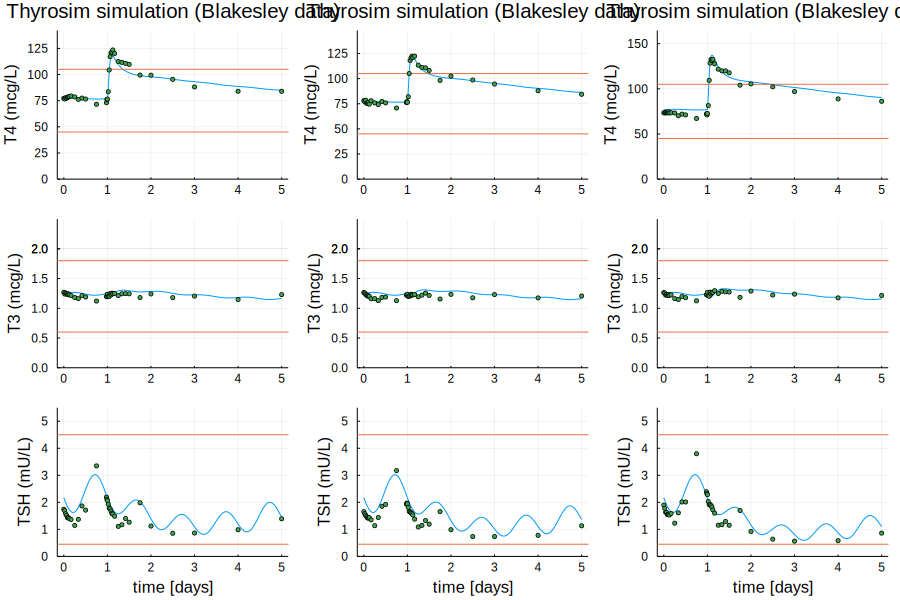

In [8]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = initial_guess

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
find_patient_ic!(ic, p, 30)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600")

plot(a, b, c, layout=(1, 3), size=(900, 600))

## Blakesley post fit

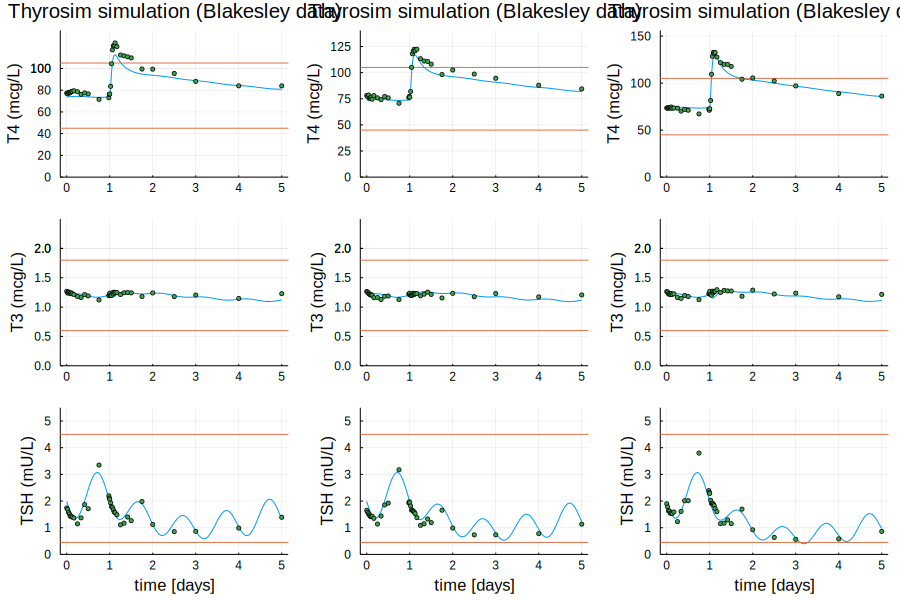

In [13]:
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = result.minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
find_patient_ic!(ic, p, 30)
# set_patient_ic!(ic, p, T4_init_400, T3_init_400, TSH_init_400)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
find_patient_ic!(ic, p, 30)
# set_patient_ic!(ic, p, T4_init_450, T3_init_450, TSH_init_450)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
find_patient_ic!(ic, p, 30)
# set_patient_ic!(ic, p, T4_init_600, T3_init_600, TSH_init_600, steady_state=true)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600")

plot(a, b, c, layout=(1, 3), size=(900, 600))

## Jonklaas postfit

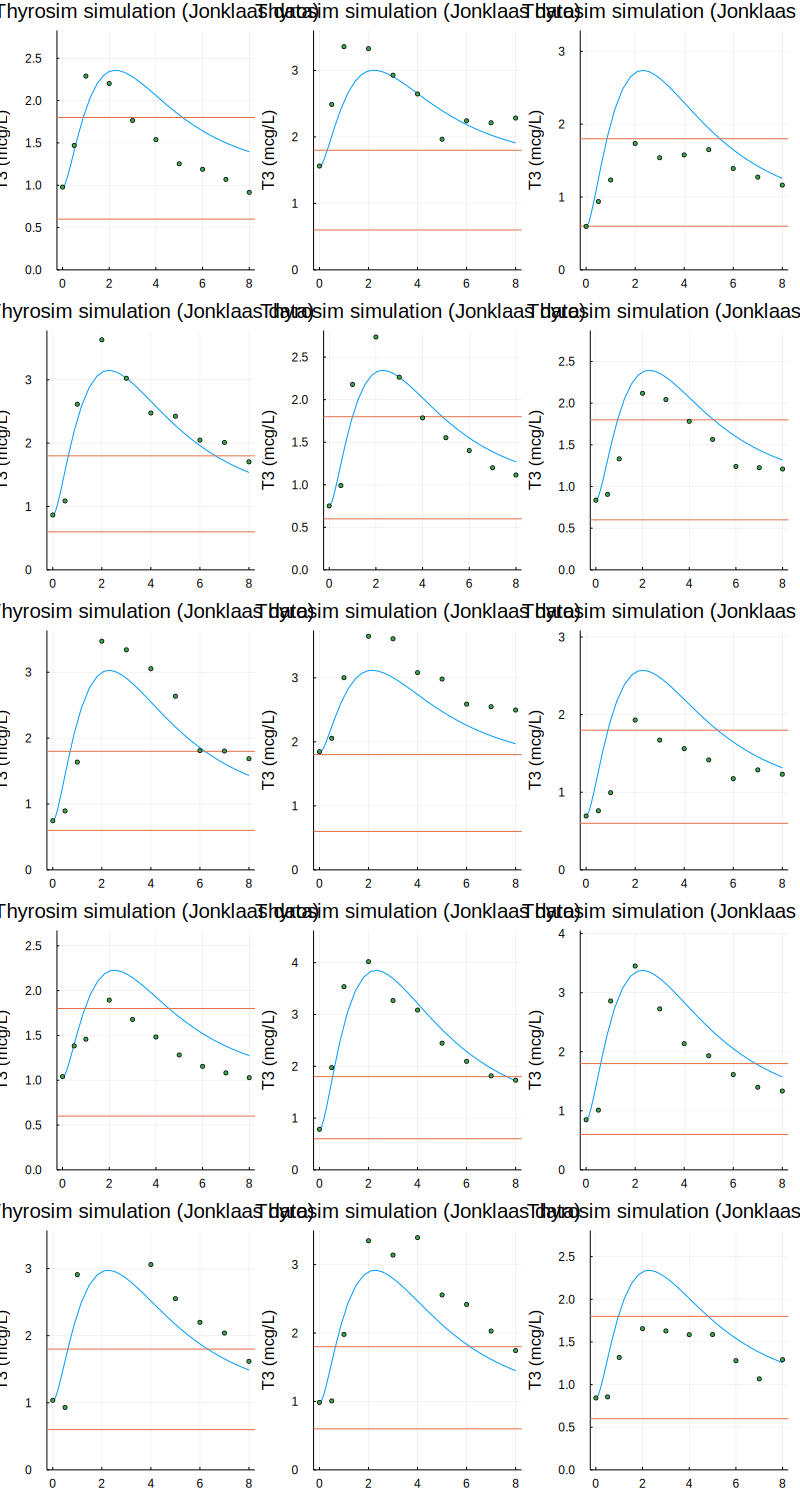

In [19]:
graphs = Vector{Any}(undef, 15)
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = result.minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    graphs[i] = plot_jonklaas_T3only(sol, patient_t3[i, :])
end
plot(graphs..., layout=(5, 3), size=(800, 1500))

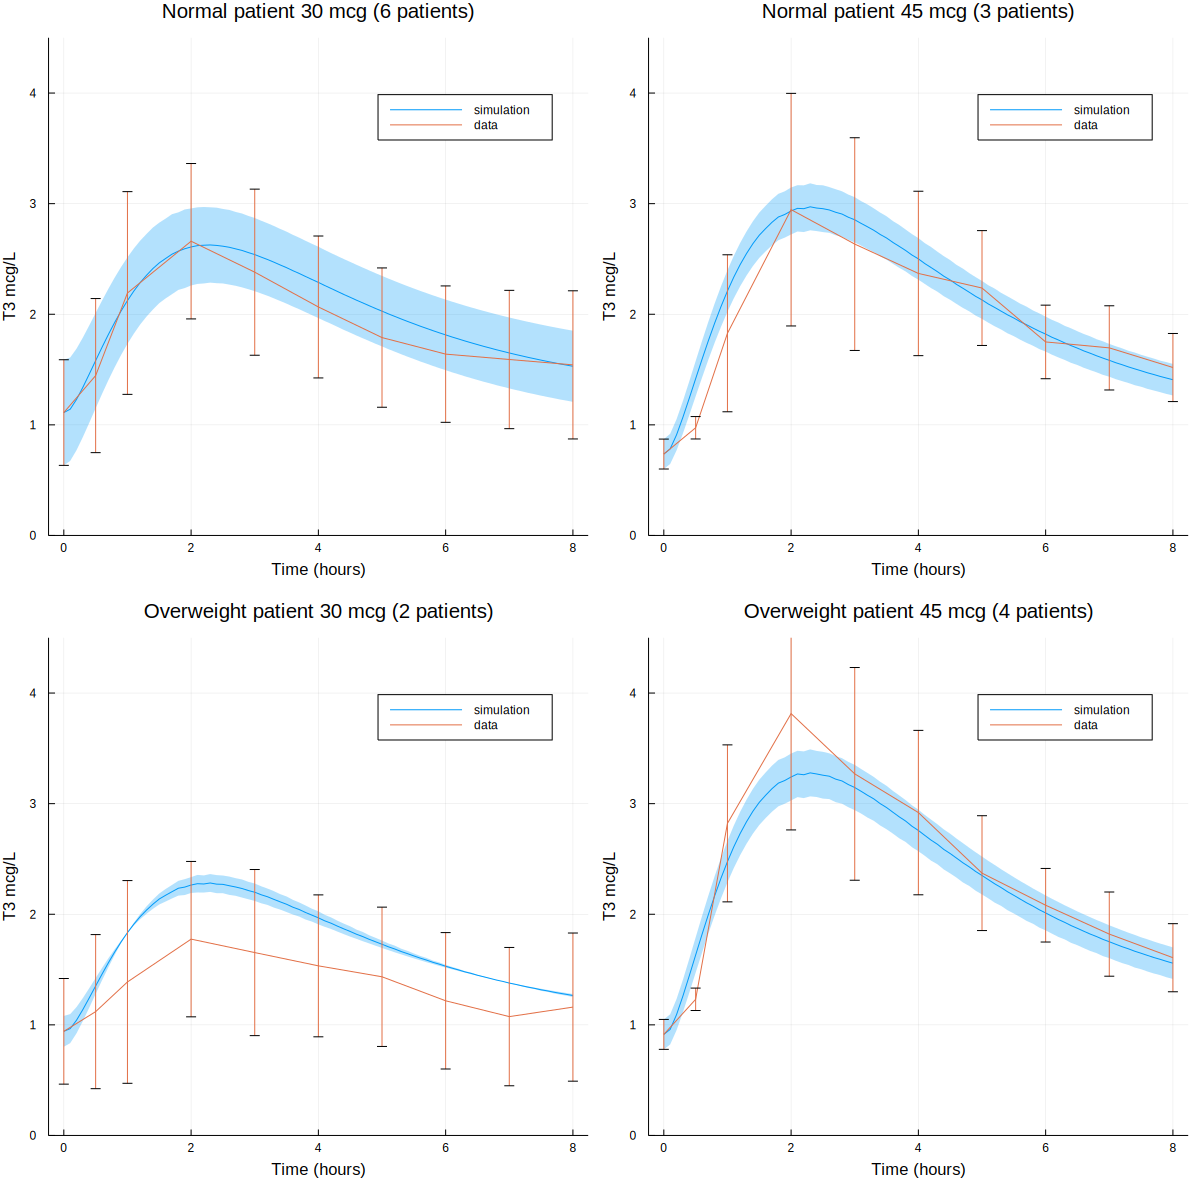

In [20]:
function jonklass_plot()
    jonklaas_times_simulation = collect(0.0:0.1:8.0)
    jonklaas_times_realdata = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0] # same time invervals as data
    points = length(jonklaas_times_simulation)
    normal_45_T4  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_T3  = [Float64[] for i in 1:points]     # 3 patients
    normal_45_TSH = [Float64[] for i in 1:points]     # 3 patients
    normal_30_T4  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_T3  = [Float64[] for i in 1:points]     # 6 patients
    normal_30_TSH = [Float64[] for i in 1:points]     # 6 patients
    overweight_45_T4  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_T3  = [Float64[] for i in 1:points] # 4 patients
    overweight_45_TSH = [Float64[] for i in 1:points] # 4 patients
    overweight_30_T4  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_T3  = [Float64[] for i in 1:points] # 2 patients
    overweight_30_TSH = [Float64[] for i in 1:points] # 2 patients

    for i in 1:15
        height, weight, sex = patient_param[i, :]
        T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
        T3dose = patient_dose[i]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        p[55] = 0.0
        p[56] = T3dose / 651.0
        cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
        p[fitting_index] = result.minimizer
        prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
        sol = solve(prob)

        BMI = weight / height^2
        if BMI < 30
            # normal patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(normal_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(normal_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(normal_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        else
            # overweight patient
            if T3dose == 30
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_30_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_30_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_30_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            else
                for (i, t) in enumerate(jonklaas_times_simulation)
                    push!(overweight_45_T4[i], sol(t)[1] * 777.0 / p[47])
                    push!(overweight_45_T3[i], sol(t)[4] * 651.0 / p[47])
                    push!(overweight_45_TSH[i], sol(t)[7] * 5.2 / p[48])
                end
            end
        end
    end

    # compute averages
    normal_45_T4_mean = mean.(normal_45_T4)      # 3 patients
    normal_45_T3_mean = mean.(normal_45_T3)      # 3 patients
    normal_45_TSH_mean = mean.(normal_45_TSH)     # 3 patients
    normal_30_T4_mean = mean.(normal_30_T4)      # 6 patients
    normal_30_T3_mean = mean.(normal_30_T3)      # 6 patients
    normal_30_TSH_mean = mean.(normal_30_TSH)     # 6 patients
    overweight_45_T4_mean = mean.(overweight_45_T4)  # 4 patients
    overweight_45_T3_mean = mean.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_mean = mean.(overweight_45_TSH) # 4 patients
    overweight_30_T4_mean = mean.(overweight_30_T4)  # 2 patients
    overweight_30_T3_mean = mean.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_mean = mean.(overweight_30_TSH) # 2 patients

    # compute sample standard deviations
    normal_45_T4_std = std.(normal_45_T4)      # 3 patients
    normal_45_T3_std = std.(normal_45_T3)      # 3 patients
    normal_45_TSH_std = std.(normal_45_TSH)     # 3 patients
    normal_30_T4_std = std.(normal_30_T4)      # 6 patients
    normal_30_T3_std = std.(normal_30_T3)      # 6 patients
    normal_30_TSH_std = std.(normal_30_TSH)     # 6 patients
    overweight_45_T4_std = std.(overweight_45_T4)  # 4 patients
    overweight_45_T3_std = std.(overweight_45_T3)  # 4 patients
    overweight_45_TSH_std = std.(overweight_45_TSH) # 4 patients
    overweight_30_T4_std = std.(overweight_30_T4)  # 2 patients
    overweight_30_T3_std = std.(overweight_30_T3)  # 2 patients
    overweight_30_TSH_std = std.(overweight_30_TSH); # 2 patients

    # now add data
    normal_45_T4_data  = zeros(10, 3)     # 3 patients
    normal_45_T3_data  = zeros(10, 3)     # 3 patients
    normal_45_TSH_data = zeros(10, 3)     # 3 patients
    normal_30_T4_data  = zeros(10, 6)     # 6 patients
    normal_30_T3_data  = zeros(10, 6)     # 6 patients
    normal_30_TSH_data = zeros(10, 6)     # 6 patients
    overweight_45_T4_data  = zeros(10, 4) # 4 patients
    overweight_45_T3_data  = zeros(10, 4) # 4 patients
    overweight_45_TSH_data = zeros(10, 4) # 4 patients
    overweight_30_T4_data  = zeros(10, 2) # 2 patients
    overweight_30_T3_data  = zeros(10, 2) # 2 patients
    overweight_30_TSH_data = zeros(10, 2) # 2 patients

    normal_45_counter = 1
    normal_30_counter = 1
    overweight_45_counter = 1
    overweight_30_counter = 1
    for i in 1:15
        height, weight, sex = patient_param[i, :]
        BMI = weight / height^2
        T3dose = patient_dose[i]

        if BMI < 30
            # normal patient
            if T3dose == 30
                normal_30_T4_data[:, normal_30_counter] .= patient_t4[i, :]
                normal_30_T3_data[:, normal_30_counter] .= patient_t3[i, :]
                normal_30_TSH_data[:, normal_30_counter] .= patient_tsh[i, :]
                normal_30_counter += 1
            else
                normal_45_T4_data[:, normal_45_counter] .= patient_t4[i, :]
                normal_45_T3_data[:, normal_45_counter] .= patient_t3[i, :]
                normal_45_TSH_data[:, normal_45_counter] .= patient_tsh[i, :]
                normal_45_counter += 1
            end
        else
            # overweight patient
            if T3dose == 30
                overweight_30_T4_data[:, overweight_30_counter] .= patient_t4[i, :]
                overweight_30_T3_data[:, overweight_30_counter] .= patient_t3[i, :]
                overweight_30_TSH_data[:, overweight_30_counter] .= patient_tsh[i, :]
                overweight_30_counter += 1
            else
                overweight_45_T4_data[:, overweight_45_counter] .= patient_t4[i, :]
                overweight_45_T3_data[:, overweight_45_counter] .= patient_t3[i, :]
                overweight_45_TSH_data[:, overweight_45_counter] .= patient_tsh[i, :]
                overweight_45_counter += 1
            end
        end
    end

    # mean and std of data
    normal_45_T3_data_mean = mean(normal_45_T3_data, dims=2)
    normal_30_T3_data_mean = mean(normal_30_T3_data, dims=2)
    overweight_45_T3_data_mean = mean(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_mean = mean(overweight_30_T3_data, dims=2)
    normal_45_T3_data_std = std(normal_45_T3_data, dims=2)
    normal_30_T3_data_std = std(normal_30_T3_data, dims=2)
    overweight_45_T3_data_std = std(overweight_45_T3_data, dims=2)
    overweight_30_T3_data_std = std(overweight_30_T3_data, dims=2);

    # normal patients 45 mcg T4 plot
    normal_45_graph = plot(jonklaas_times_simulation, normal_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Normal patient 45 mcg (3 patients)")
    normal_45_graph = plot!(normal_45_graph, jonklaas_times_realdata, normal_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # normal patients 30 mcg T4 plot
    normal_30_graph = plot(jonklaas_times_simulation, normal_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_30_T3_std, fillalpha=.3, title="Normal patient 30 mcg (6 patients)")
    normal_30_graph = plot!(normal_30_graph, jonklaas_times_realdata, normal_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std)

    # overweight patients 45 mcg T4 plot
    overweight_45_graph = plot(jonklaas_times_simulation, overweight_45_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=normal_45_T3_std, fillalpha=.3, title="Overweight patient 45 mcg (4 patients)")
    overweight_45_graph = plot!(overweight_45_graph, jonklaas_times_realdata, overweight_45_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_45_T3_data_std)

    # overweight patients 30 mcg T4 plot
    overweight_30_graph = plot(jonklaas_times_simulation, overweight_30_T3_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="simulation", ribbon=overweight_30_T3_std, fillalpha=.3, title="Overweight patient 30 mcg (2 patients)")
    overweight_30_graph = plot!(overweight_30_graph, jonklaas_times_realdata, overweight_30_T3_data_mean, ylabel="T3 mcg/L", xlabel="Time (hours)", ylim=(0, 4.5), 
        label="data", yerror=normal_30_T3_data_std);
    
    combine = plot(normal_30_graph, normal_45_graph, 
        overweight_30_graph, overweight_45_graph, 
        layout=(2, 2), size=(1200, 1200))
    return combine
end
combine = jonklass_plot()